In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import pandas as pd
import time
import igraph as ig
import random

In [2]:
def create_graph_from_files(ids_file_path, arcs_file_path, max_lines=None, max_nodes=None, max_edges=None):
    """
    Crea il grafo diretto G utilizzando solo le prime max_lines righe del file .arcs e max_nodes nodi.
    Può anche limitare il numero di nodi e archi per migliorare le performance.
    Ritorna G (grafo diretto) e U_G (versione non diretta di G).
    
    - max_lines: Numero massimo di righe da processare (opzionale).
    - max_nodes: Numero massimo di nodi da aggiungere (opzionale).
    - max_edges: Numero massimo di archi da aggiungere (opzionale).
    """
    G = nx.DiGraph()  # Crea il grafo diretto vuoto

    # Dizionari per mappare ID dei nodi ai nomi delle pagine e viceversa
    id_to_name = {}
    name_to_id = {}

    # Lettura del file .ids per popolare i dizionari id_to_name e name_to_id
    with open(ids_file_path, 'r', encoding='utf-8') as ids_file:
        for i, line in enumerate(ids_file):
            if max_nodes and i >= max_nodes:  # Se raggiungiamo il limite di nodi, fermati
                break
            name = line.strip()  # Rimuove eventuali spazi bianchi
            id_to_name[i] = name  # Mappa l'ID al nome della pagina
            name_to_id[name] = i  # Mappa il nome al rispettivo ID

    # Lettura del file .arcs per aggiungere gli archi al grafo G, con limiti opzionali
    edges = []
    edge_count = 0
    with open(arcs_file_path, 'r') as arcs_file:
        for i, line in enumerate(arcs_file):
            if max_lines and i >= max_lines:  # Se max_lines è specificato e raggiunto, fermati
                break
            if max_edges and edge_count >= max_edges:  # Se raggiungiamo il limite di archi, fermati
                break
            u, v = map(int, line.strip().split())  # Divide la riga in due ID (u, v)
            if max_nodes is None or (u < max_nodes and v < max_nodes):  # Considera solo i nodi nel limite di max_nodes
                edges.append((u, v))
                edge_count += 1

    # Aggiungi tutti gli archi in un batch
    G.add_edges_from(edges)

    # Crea la versione non diretta del grafo G (U(G)) per future analisi
    U_G = G.to_undirected()

    return G, U_G, id_to_name, name_to_id


# Impostazioni dei percorsi e numero massimo di righe da leggere
ids_file_path = 'itwiki-2013.ids'
arcs_file_path = 'itwiki-2013.arcs'
#max_lines = 15000000  # Imposta il numero massimo di righe da leggere per il grafo
max_lines = 50000 #solo per test

# Crea il grafo utilizzando solo le prime max_lines righe
G, U_G, id_to_name, name_to_id = create_graph_from_files(ids_file_path, arcs_file_path, max_lines)  

print(f"Numero di nodi nel grafo: {G.number_of_nodes()}\nNumero di archi nel grafo: {G.number_of_edges()}")

Numero di nodi nel grafo: 10601
Numero di archi nel grafo: 50000


#### DOMANDA 1/I - Calcola la distribuzione degli indegree in G: quali sono le prime 10 pagine con il maggior indegree?

In [3]:
def calculate_degree(graph, degree_type='total'):
    """
    Calcola l'indegree, l'outdegree o il grado totale per ciascun nodo nel grafo e restituisce un dizionario con i valori.
    
    Parametri:
    - graph: Il grafo su cui calcolare i gradi.
    - degree_type: Specifica se calcolare 'in', 'out' o 'total' degree (default è 'total' per grafi non diretti).
    
    Ritorna:
    - Dizionario con i gradi (indegree, outdegree o grado totale) per ciascun nodo.
    """
    degree_dict = {}
    
    if degree_type == 'out':  # Calcola l'outdegree
        for u, v in graph.edges():
            if u in degree_dict:
                degree_dict[u] += 1
            else:
                degree_dict[u] = 1
    elif degree_type == 'in':  # Calcola l'indegree
        for u, v in graph.edges():
            if v in degree_dict:
                degree_dict[v] += 1
            else:
                degree_dict[v] = 1
    elif degree_type == 'total':  # Calcola il grado totale (per grafi non diretti)
        for u, v in graph.edges():
            if u in degree_dict:
                degree_dict[u] += 1
            else:
                degree_dict[u] = 1
            if v in degree_dict:
                degree_dict[v] += 1
            else:
                degree_dict[v] = 1

    # Assicurati che ogni nodo sia presente nel dizionario, anche quelli senza archi
    for node in graph.nodes():
        if node not in degree_dict:
            degree_dict[node] = 0  # I nodi senza collegamenti hanno grado 0

    return degree_dict


def print_top_10_degree(degree_dict, id_to_name, degree_type='in'):
    """
    Stampa i primi 10 nodi con il maggior indegree o outdegree in base al dizionario passato.
    
    Parametri:
    - degree_dict: Dizionario con i valori di grado (indegree/outdegree).
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - degree_type: Tipo di grado ('in' o 'out') da stampare.
    """
    # Ordina i nodi in base al loro grado in ordine decrescente e seleziona i primi 10
    top_10 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    # Stampa i primi 10 nodi con il maggior grado
    degree_name = "indegree" if degree_type == 'in' else "outdegree"
    print(f"Prime 10 pagine con il maggior {degree_name}:")
    for index, (node_id, degree) in enumerate(top_10, start=1):
        page_name = id_to_name.get(node_id, "Nome non disponibile")
        print(f"{index}) {page_name}, ID: {node_id}, {degree_name.capitalize()}: {degree}")

In [4]:
in_degree_dict = calculate_degree(G, degree_type='in')
print_top_10_degree(in_degree_dict, id_to_name, degree_type='in')

Prime 10 pagine con il maggior indegree:
1) Città del Vaticano, ID: 916, Indegree: 639
2) Milano, ID: 289682, Indegree: 633
3) 2003, ID: 396906, Indegree: 618
4) Istituto religioso, ID: 923, Indegree: 618
5) 1974, ID: 397123, Indegree: 602
6) Di diritto pontificio, ID: 922, Indegree: 583
7) Moderatore supremo, ID: 924, Indegree: 582
8) Sigle degli istituti di perfezione cattolici, ID: 928, Indegree: 543
9) Religioso (cristianesimo), ID: 920, Indegree: 514
10) Congregazione religiosa, ID: 919, Indegree: 510


In [5]:
def plot_degree_distribution(degree_dict, degree_type='out'):
    """
    Visualizza la distribuzione dei gradi (indegree o outdegree) e la loro rappresentazione log-log
    fianco a fianco in due grafici.
    
    Parametri:
    - degree_dict: Dizionario con i valori dei gradi (indegree/outdegree).
    - degree_type: Specifica se stampare 'in' o 'out' degree (default 'out').
    """
    degree_count = {}
    for degree in degree_dict.values():
        degree_count[degree] = degree_count.get(degree, 0) + 1  # Conta quanti nodi hanno un certo grado

    degrees = list(degree_count.keys())  # Gradi unici
    frequencies = [degree_count[degree] for degree in degrees]  # Frequenza per ogni grado

    # Prepara il titolo e le etichette
    degree_name = "Out-degree" if degree_type == 'out' else "In-degree"
    title = f'{degree_name} Distribution'
    
    # Crea due sottoplot fianco a fianco
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Grafico a barre
    axs[0].bar(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[0].set_xlabel(degree_name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(title)
    axs[0].set_xlim([0, 200])  # Limita l'asse x
    axs[0].set_ylim([0, 60000])  # Limita l'asse y
    axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # Grafico log-log
    axs[1].scatter(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(f'{degree_name} (log scale)')
    axs[1].set_ylabel('Frequency (log scale)')
    axs[1].set_title(f'{degree_name} Distribution (Log-Log Plot)')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()

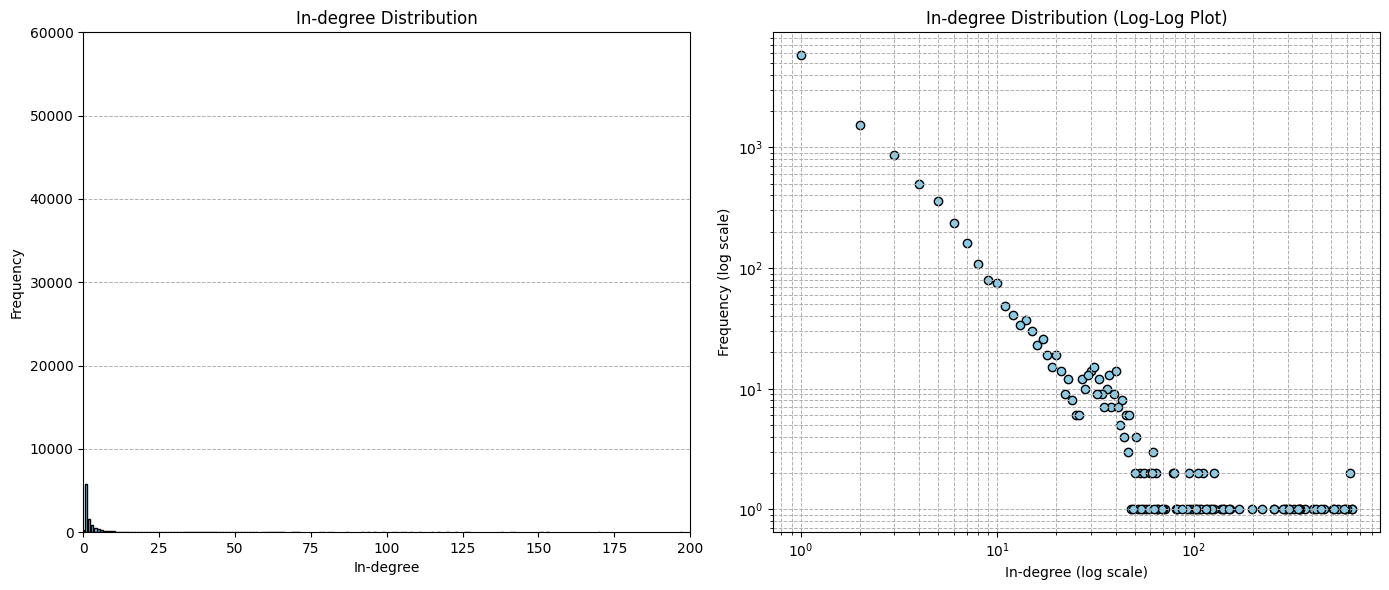

In [6]:
plot_degree_distribution(in_degree_dict, degree_type='in')

#### DOMANDA 1/II - Calcola la distribuzione degli outdegree in G: quali sono le prime 10 pagine con il maggior outdegree?

In [7]:
out_degree_dict = calculate_degree(G, degree_type='out')
print_top_10_degree(out_degree_dict, id_to_name, degree_type='out')

Prime 10 pagine con il maggior outdegree:
1) Sigle degli istituti di perfezione cattolici, ID: 928, Outdegree: 865
2) Suora, ID: 930, Outdegree: 729
3) Beatificazioni celebrate da Giovanni Paolo II, ID: 912, Outdegree: 625
4) Beatificazioni approvate da Benedetto XVI, ID: 1277, Outdegree: 391
5) Città del Vaticano, ID: 916, Outdegree: 375
6) Canonizzazioni celebrate da Giovanni Paolo II, ID: 1293, Outdegree: 271
7) Denis, ID: 395, Outdegree: 236
8) Arcidiocesi di Saint Louis, ID: 1288, Outdegree: 152
9) Famiglia Cristiana, ID: 701, Outdegree: 140
10) Gemma Galgani, ID: 1495, Outdegree: 136


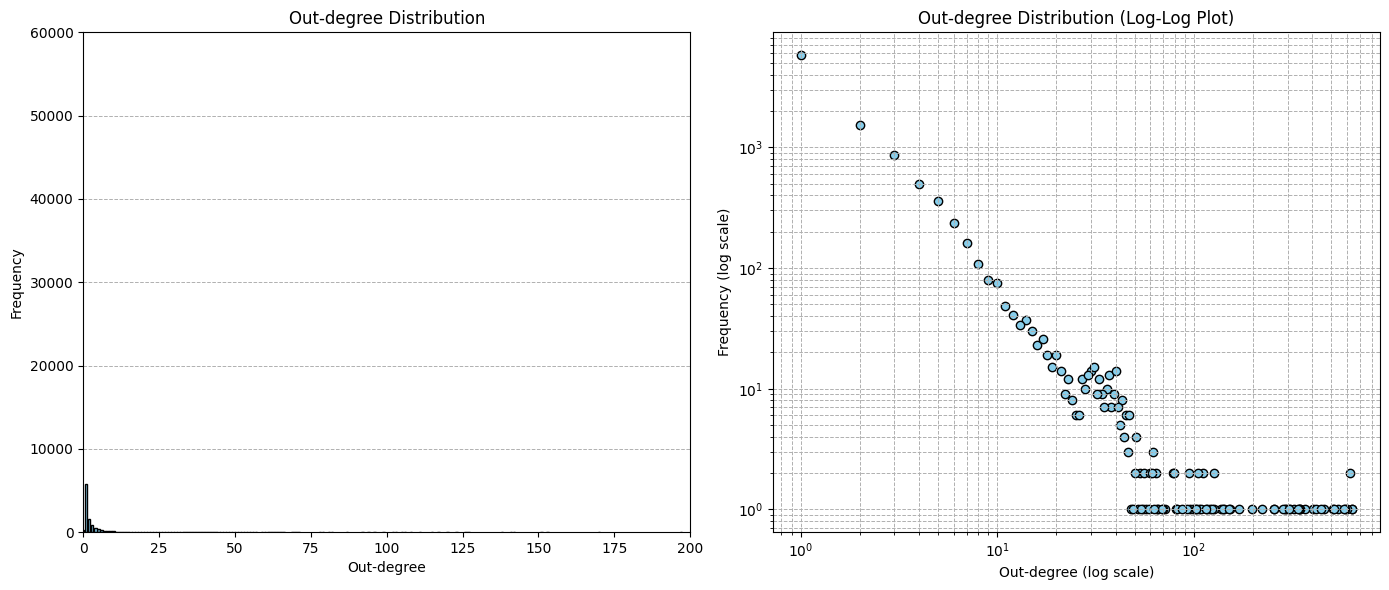

In [8]:
plot_degree_distribution(in_degree_dict, degree_type='out')

#### DOMANDA 1/III - Considerando il grafo non diretto U(G), calcola la distribuzione dei gradi: quali sono le prime 10 pagine con il grado maggiore?

In [9]:
# Dato che parliamo di un grafo non diretto, il degree è la somma di archi in entrata e in uscita per ciascun nodo
# Calcola la distribuzione dei gradi (degree) nel grafo non diretto U_G
degree_dict = calculate_degree(U_G, degree_type='total')  # 'total' rappresenta il grado complessivo

print_top_10_degree(degree_dict, id_to_name, degree_type='total')

Prime 10 pagine con il maggior outdegree:
1) Città del Vaticano, ID: 916, Outdegree: 1009
2) Sigle degli istituti di perfezione cattolici, ID: 928, Outdegree: 876
3) Suora, ID: 930, Outdegree: 741
4) Istituto religioso, ID: 923, Outdegree: 642
5) Milano, ID: 289682, Outdegree: 633
6) Beatificazioni celebrate da Giovanni Paolo II, ID: 912, Outdegree: 625
7) Moderatore supremo, ID: 924, Outdegree: 623
8) 2003, ID: 396906, Outdegree: 618
9) Di diritto pontificio, ID: 922, Outdegree: 611
10) 1974, ID: 397123, Outdegree: 602


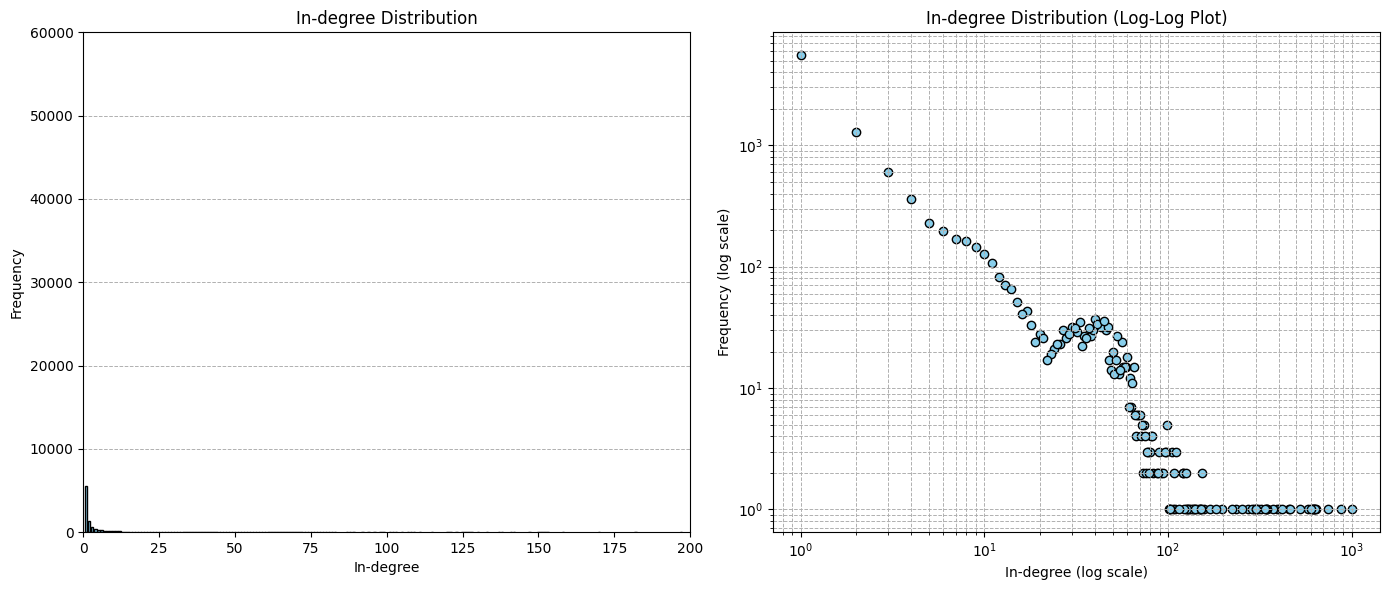

In [10]:
plot_degree_distribution(degree_dict, degree_type='total')

## DOMANDA 2/A - Considerando U(G) e limitandosi alla sua componente connessa più grande V', calcola esattamente il diametro del grafo indotto dai vertici in V'. Ripeti la domanda rimuovendo dai grafi i nodi il cui nome contiene la stringa "disambigua".

In [11]:
def find_largest_connected_component(graph):
    """
    Trova la componente connessa più grande in un grafo non diretto usando BFS.
    Restituisce il sottografo della LCC.
    """
    def bfs_component(start_node, visited):
        queue = deque([start_node])
        component = set([start_node])

        while queue:
            node = queue.popleft()
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    visited.add(neighbor)
                    component.add(neighbor)
                    queue.append(neighbor)
        return component

    visited = set()
    largest_component = set()

    for node in graph.nodes():
        if node not in visited:
            visited.add(node)
            component = bfs_component(node, visited)
            if len(component) > len(largest_component):
                largest_component = component

    return graph.subgraph(largest_component).copy()

def bfs_eccentricity(graph, start_node):
    """
    Calcola l'eccentricità di un nodo usando BFS.
    Restituisce l'eccentricità e il nodo più distante.
    """
    visited = {start_node: 0}
    queue = deque([start_node])
    farthest_node = start_node
    max_distance = 0

    while queue:
        node = queue.popleft()
        current_distance = visited[node]

        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                visited[neighbor] = current_distance + 1
                queue.append(neighbor)

                if visited[neighbor] > max_distance:
                    max_distance = visited[neighbor]
                    farthest_node = neighbor

    return max_distance, farthest_node

def bidirectional_bfs(graph, start_node, target_node):
    """
    Implementa una BFS bidirezionale tra start_node e target_node.
    Restituisce la distanza minima tra i due nodi o -1 se non sono connessi.
    """
    if start_node == target_node:
        return 0

    start_visited = {start_node: 0}
    target_visited = {target_node: 0}
    
    start_queue = deque([start_node])
    target_queue = deque([target_node])
    
    while start_queue and target_queue:
        # Espansione dalla parte del nodo di partenza
        if start_queue:
            node = start_queue.popleft()
            current_distance = start_visited[node]

            for neighbor in graph.neighbors(node):
                if neighbor in target_visited:
                    return current_distance + target_visited[neighbor] + 1
                if neighbor not in start_visited:
                    start_visited[neighbor] = current_distance + 1
                    start_queue.append(neighbor)

        # Espansione dalla parte del nodo di arrivo
        if target_queue:
            node = target_queue.popleft()
            current_distance = target_visited[node]

            for neighbor in graph.neighbors(node):
                if neighbor in start_visited:
                    return current_distance + start_visited[neighbor] + 1
                if neighbor not in target_visited:
                    target_visited[neighbor] = current_distance + 1
                    target_queue.append(neighbor)

    return -1  # Se non esiste un percorso tra i due nodi


def bfs_fringe(graph, start_node, depth):
    """
    Trova i nodi a distanza 'depth' dal nodo di partenza usando BFS.
    """
    visited = {start_node: 0}
    queue = deque([(start_node, 0)])  # (nodo, distanza)
    fringe = set()

    while queue:
        node, dist = queue.popleft()

        if dist == depth:
            fringe.add(node)
        elif dist < depth:  # Continuiamo solo finché non superiamo la profondità richiesta
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    visited[neighbor] = dist + 1
                    queue.append((neighbor, dist + 1))

    return fringe

def ifub_diameter(graph):
    """
    Calcola il diametro del grafo usando l'algoritmo iFub ottimizzato con BFS bidirezionale.
    """
    # Step 1: Inizia con un nodo qualsiasi
    start_node = list(graph.nodes())[0]

    # Step 2: Calcola l'eccentricità iniziale con BFS e trova il nodo più lontano
    _, farthest_node = bfs_eccentricity(graph, start_node)

    # Step 3: Imposta i limiti iniziali
    lb, farthest_node = bfs_eccentricity(graph, farthest_node)
    ub = 2 * lb  # Upper bound è il doppio del limite inferiore
    i = lb

    while ub > lb:
        # Step 4: Trova la fringe a distanza 'i' dal nodo più lontano
        fringe_nodes = bfs_fringe(graph, farthest_node, i)

        # Step 5: Trova l'eccentricità massima tra i nodi nella fringe con BFS bidirezionale
        max_eccentricity_in_fringe = 0
        for node in fringe_nodes:
            eccentricity = bidirectional_bfs(graph, farthest_node, node)
            max_eccentricity_in_fringe = max(max_eccentricity_in_fringe, eccentricity)

        lb = max(lb, max_eccentricity_in_fringe)
        ub = 2 * (i - 1)
        i -= 1

    return lb  # Il diametro si trova quando i limiti convergono

def remove_disambigua_nodes(graph, id_to_name):
    """
    Rimuove i nodi che contengono 'disambigua' nel nome e ritorna il grafo ridotto.
    """
    nodes_to_remove = [node for node in graph.nodes() if "disambigua" in id_to_name.get(node, "").lower()]
    graph.remove_nodes_from(nodes_to_remove)
    return graph


def pipeline(graph, id_to_name):
    """
    Calcola il diametro del grafo con e senza nodi 'disambigua'.
    """
    # Calcolo con i nodi 'disambigua'
    start_time = time.time()
    print("Calcolo con nodi 'disambigua'...")
    largest_cc = find_largest_connected_component(graph)
    diameter = ifub_diameter(largest_cc)
    print(f"Diametro iFub: {diameter}")
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")
    
    # Calcolo senza nodi 'disambigua'
    start_time = time.time()
    print("Rimozione dei nodi 'disambigua' e ricalcolo...")
    graph_cleaned = remove_disambigua_nodes(graph.copy(), id_to_name)
    largest_cc = find_largest_connected_component(graph_cleaned)
    diameter = ifub_diameter(largest_cc)
    print(f'Diametro iFub): {diameter}')
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")

pipeline(U_G, id_to_name)

Calcolo con nodi 'disambigua'...
Diametro iFub: 10
Tempo di esecuzione: 2.06 secondi

Rimozione dei nodi 'disambigua' e ricalcolo...
Diametro iFub): 10
Tempo di esecuzione: 2.47 secondi



## DOMANDA 3/1 - Considerando U(G), costruisci un algoritmo per trovare una Clique Massimale. Riesci a trovare due di essi anziché solo uno?


In [12]:
def bron_kerbosch(R, P, X, graph, maximal_cliques, max_cliques_needed=2):
    """
    Algoritmo Bron-Kerbosch modificato per trovare cliques massimali.
    
    Parametri:
    - R: Insieme dei nodi che sono già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono ancora essere aggiunti alla clique.
    - X: Insieme dei nodi che non possono più essere inclusi nella clique (già processati).
    - graph: Il grafo su cui viene eseguito l'algoritmo.
    - maximal_cliques: Lista dove vengono salvate le cliques massimali trovate.
    - max_cliques_needed: Numero massimo di cliques da trovare (valore di default 2).
    
    Logica:
    - L'algoritmo continua finché non ci sono più candidati in P o nodi in X.
    - Se la clique formata (R) ha almeno 3 nodi ed è massimale, la aggiunge a `maximal_cliques`.
    - Il pivot viene scelto da P ∪ X e i nodi di P che non sono vicini del pivot vengono processati.
    - Ricorsivamente, vengono trovate tutte le cliques massimali.
    """

    # Se P e X sono vuoti, significa che abbiamo trovato una clique massimale.
    if not P and not X:
        if len(R) >= 3:  # Consideriamo solo cliques con almeno 3 nodi (clique non banali)
            maximal_cliques.append(R)  # Aggiungi la clique massimale trovata alla lista
        return

    # Se abbiamo già trovato il numero massimo di cliques richieste, fermati.
    if len(maximal_cliques) >= max_cliques_needed:
        return

    # Scegli un nodo pivot da P ∪ X per limitare il numero di ricorsioni.
    pivot = next(iter(P.union(X)), None)  # Prende un nodo qualsiasi da P ∪ X
    if pivot is None:  # Se non esiste un pivot (caso limite), termina
        return

    # Processa i nodi in P che non sono vicini del pivot
    # L'algoritmo evita i nodi che sono vicini del pivot per migliorare l'efficienza.
    for node in P - set(graph.neighbors(pivot)):
        # Ricorsivamente chiama Bron-Kerbosch aggiornando R, P, e X
        # Unisci `node` con la clique corrente (R), e aggiorna i candidati (P) e i nodi esclusi (X)
        bron_kerbosch(
            R.union([node]),  # Aggiungi il nodo corrente alla clique R
            P.intersection(graph.neighbors(node)),  # Limita P ai vicini del nodo aggiunto
            X.intersection(graph.neighbors(node)),  # Limita X ai vicini del nodo aggiunto
            graph, maximal_cliques, max_cliques_needed
        )
        P.remove(node)  # Rimuovi il nodo processato da P
        X.add(node)     # Aggiungi il nodo processato a X (ora è escluso)

def find_maximal_cliques_bron_kerbosch(graph, id_to_name, max_cliques_needed=2):
    """
    Funzione che avvia l'algoritmo Bron-Kerbosch per trovare più cliques massimali non banali.

    Parametri:
    - graph: Il grafo in cui si vogliono trovare le cliques massimali.
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - max_cliques_needed: Numero massimo di cliques massimali da trovare.

    Ritorna:
    - Una lista con le cliques massimali trovate.
    """
    R = set()  # Insieme iniziale vuoto (clique corrente)
    P = set(graph.nodes())  # Tutti i nodi sono candidati iniziali per essere inclusi nella clique
    X = set()  # Insieme vuoto, non ci sono nodi esclusi all'inizio
    
    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch per trovare le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques, max_cliques_needed)

    # Stampa le cliques massimali trovate, convertendo gli ID nei nomi
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]  # Converte gli ID dei nodi nei loro nomi
        print(f"Clique massimale {idx}: {clique_names}")  # Stampa la clique massimale con i nomi dei nodi

    return maximal_cliques  # Restituisce la lista delle cliques massimali trovate

# Esegui l'algoritmo per trovare due cliques massimali con i nomi dei nodi
maximal_cliques = find_maximal_cliques_bron_kerbosch(U_G, id_to_name, max_cliques_needed=2)

Clique massimale 1: ['Cabra de Mora', 'El Castellar', 'Formiche Alto', 'Spagna']
Clique massimale 2: ['Cabra de Mora', 'El Castellar', 'Aragona', 'Formiche Alto']
Clique massimale 3: ['Cabra de Mora', 'El Castellar', 'Formiche Alto', 'Comunità autonome della Spagna']
Clique massimale 4: ['Cabra de Mora', 'El Castellar', 'Alcalá de la Selva']


#### DOMANDA 4 - 

#### Ripeti le domande scelte, utilizzando il dataset enwiki-2023. Non usare NetworkX

# 1

In [13]:
def create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines=None, max_nodes=None, max_edges=None):
    """
    Crea il grafo diretto G utilizzando un limite opzionale per max_lines righe del file .arcs.
    Può anche limitare il numero di nodi e archi nel grafo per migliorare le performance.
    Ritorna G (grafo diretto) e U_G (versione non diretta di G).
    
    - max_lines: Numero massimo di righe da processare (opzionale).
    - max_nodes: Numero massimo di nodi da aggiungere (opzionale).
    - max_edges: Numero massimo di archi da aggiungere (opzionale).
    """
    # Crea il grafo vuoto
    G = ig.Graph(directed=True)
    
    # Dizionari per mappare ID dei nodi ai nomi delle pagine e viceversa
    id_to_name = {}
    name_to_id = {}

    # Lettura del file .ids per popolare i dizionari id_to_name e name_to_id
    with open(ids_file_path, 'r', encoding='utf-8') as ids_file:
        for i, line in enumerate(ids_file):
            if max_nodes and i >= max_nodes:  # Se abbiamo raggiunto il limite di nodi
                break
            name = line.strip()  # Rimuove eventuali spazi bianchi
            id_to_name[i] = name  # Mappa l'ID al nome della pagina
            name_to_id[name] = i  # Mappa il nome al rispettivo ID
            G.add_vertex(name=name)  # Aggiunge il nodo nel grafo

    # Lettura del file .arcs per aggiungere gli archi al grafo G, limitato a max_lines righe
    edges = []
    edge_count = 0
    with open(arcs_file_path, 'r') as arcs_file:
        for i, line in enumerate(arcs_file):
            if max_lines and i >= max_lines:  # Se max_lines è specificato e raggiunto, fermati
                break
            if max_edges and edge_count >= max_edges:  # Se raggiungiamo il numero massimo di archi, fermati
                break
            u, v = map(int, line.strip().split())  # Divide la riga in due ID (u, v)
            if u < len(G.vs) and v < len(G.vs):  # Aggiungi solo se gli ID dei nodi sono validi
                edges.append((u, v))
                edge_count += 1

    # Aggiungi tutti gli archi in un batch
    G.add_edges(edges)

    # Crea la versione non diretta del grafo G per future analisi
    U_G = G.as_undirected()

    return G, U_G, id_to_name, name_to_id


# Impostazioni dei percorsi e limiti
ids_file_path = 'enwiki-2023.ids'
arcs_file_path = 'enwiki-2023.arcs'
#max_lines = 10000000 # Numero massimo di righe di archi da processare
#max_nodes = 50000 # Numero massimo di nodi da aggiungere
max_lines = 100000 #solo per test
max_nodes = 50000 #solo per test

# Crea il grafo utilizzando solo i primi max_lines archi e i primi max_nodes nodi
G, U_G, id_to_name, name_to_id = create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines, max_nodes)

print(f"Numero di nodi nel grafo: {len(G.vs)}\nNumero di archi nel grafo: {len(G.es)}")

Numero di nodi nel grafo: 50000
Numero di archi nel grafo: 42852


In [14]:
def calculate_degree_igraph(graph, degree_type='total'):
    """
    Calcola l'indegree, l'outdegree o il grado totale per ciascun nodo nel grafo e restituisce un dizionario con i valori.
    
    Parametri:
    - graph: Il grafo su cui calcolare i gradi (usando igraph).
    - degree_type: Specifica se calcolare 'in', 'out' o 'total' degree (default è 'total' per grafi non diretti).
    
    Ritorna:
    - Dizionario con i gradi (indegree, outdegree o grado totale) per ciascun nodo.
    """
    if degree_type == 'out':  # Calcola l'outdegree
        degrees = graph.outdegree()  # Ottiene l'outdegree con igraph
    elif degree_type == 'in':  # Calcola l'indegree
        degrees = graph.indegree()  # Ottiene l'indegree con igraph
    elif degree_type == 'total':  # Calcola il grado totale per grafi non diretti
        degrees = graph.degree()  # Ottiene il grado totale con igraph

    # Crea un dizionario con i risultati
    degree_dict = {v.index: degree for v, degree in zip(graph.vs, degrees)}
    
    return degree_dict

in_degree_dict = calculate_degree_igraph(G, degree_type='in')
print_top_10_degree(in_degree_dict, id_to_name, degree_type='in')

Prime 10 pagine con il maggior indegree:
1) Iran, ID: 5100, Indegree: 3344
2) Romanization, ID: 5090, Indegree: 2782
3) Kohgiluyeh and Boyer-Ahmad province, ID: 4877, Indegree: 1365
4) Chaharmahal and Bakhtiari province, ID: 3276, Indegree: 884
5) Bushehr province, ID: 2893, Indegree: 610
6) Lurs, ID: 3274, Indegree: 541
7) Boyer-Ahmad County, ID: 4639, Indegree: 493
8) Isfahan province, ID: 5084, Indegree: 413
9) Kohgiluyeh County, ID: 2156, Indegree: 342
10) Lordegan County, ID: 3138, Indegree: 316


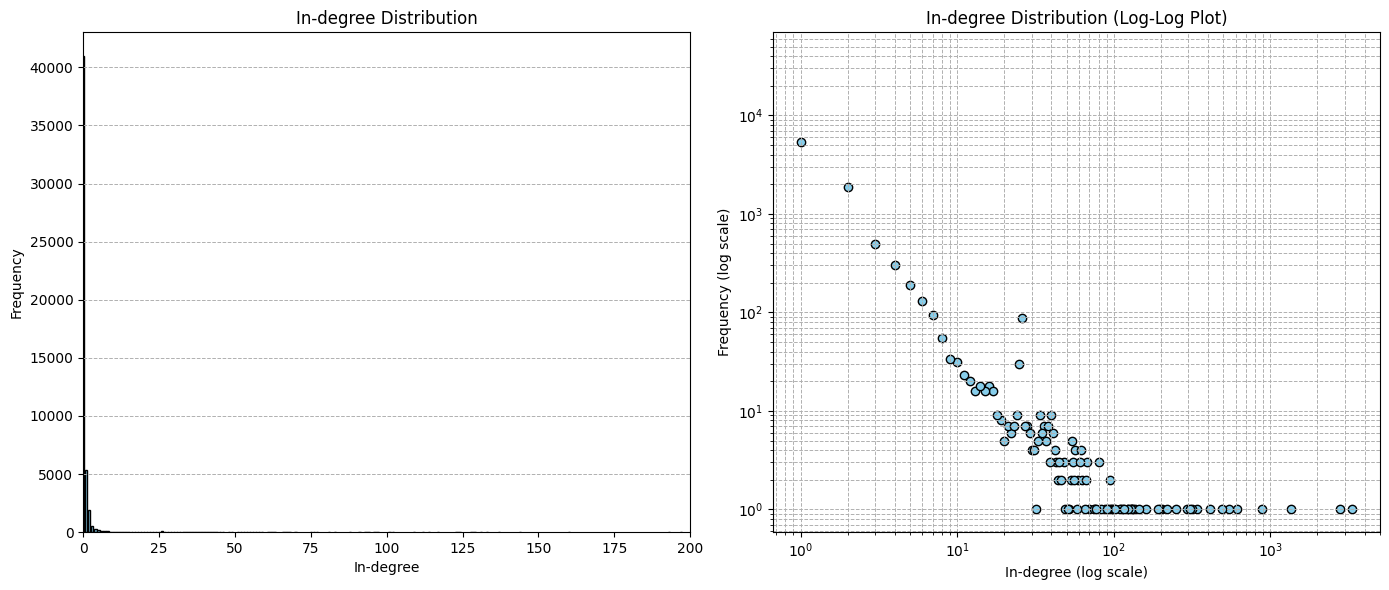

In [15]:
def plot_degree_distribution_igraph(degree_dict, degree_type='out'):
    """
    Visualizza la distribuzione dei gradi (indegree o outdegree) e la loro rappresentazione log-log
    fianco a fianco in due grafici, utilizzando igraph.
    
    Parametri:
    - degree_dict: Dizionario con i valori dei gradi (indegree/outdegree).
    - degree_type: Specifica se stampare 'in' o 'out' degree (default 'out').
    """
    degree_count = {}
    for degree in degree_dict.values():
        degree_count[degree] = degree_count.get(degree, 0) + 1  # Conta quanti nodi hanno un certo grado

    degrees = list(degree_count.keys())  # Gradi unici
    frequencies = [degree_count[degree] for degree in degrees]  # Frequenza per ogni grado

    # Prepara il titolo e le etichette
    degree_name = "Out-degree" if degree_type == 'out' else "In-degree"
    title = f'{degree_name} Distribution'
    
    # Crea due sottoplot fianco a fianco
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Grafico a barre
    axs[0].bar(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[0].set_xlabel(degree_name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(title)
    axs[0].set_xlim([0, 200])  # Limita l'asse x (puoi adattarlo in base ai tuoi dati)
    axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # Grafico log-log
    axs[1].scatter(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(f'{degree_name} (log scale)')
    axs[1].set_ylabel('Frequency (log scale)')
    axs[1].set_title(f'{degree_name} Distribution (Log-Log Plot)')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()

plot_degree_distribution_igraph(in_degree_dict, degree_type='in')

# 2

In [16]:
in_degree_dict = calculate_degree_igraph(G, degree_type='out')
print_top_10_degree(in_degree_dict, id_to_name, degree_type='out')

Prime 10 pagine con il maggior outdegree:
1) List of cities, towns and villages in Kohgiluyeh and Boyer-Ahmad Province, ID: 4878, Outdegree: 1301
2) List of cities, towns and villages in Chaharmahal and Bakhtiari Province, ID: 3275, Outdegree: 771
3) List of cities, towns and villages in Bushehr Province, ID: 2892, Outdegree: 513
4) List of cities, towns and villages in Isfahan Province, ID: 5083, Outdegree: 344
5) List of provinces, dioceses and bishops in the Church of Nigeria in 2021, ID: 8509, Outdegree: 327
6) List of populated places in Siirt Province, ID: 8173, Outdegree: 258
7) List of bishops in the Church of Nigeria in 2007, ID: 8503, Outdegree: 248
8) List of endemic and threatened plants of India, ID: 9065, Outdegree: 203
9) List of Quercus species, ID: 6754, Outdegree: 155
10) List of Anglican Communion dioceses, ID: 8521, Outdegree: 155


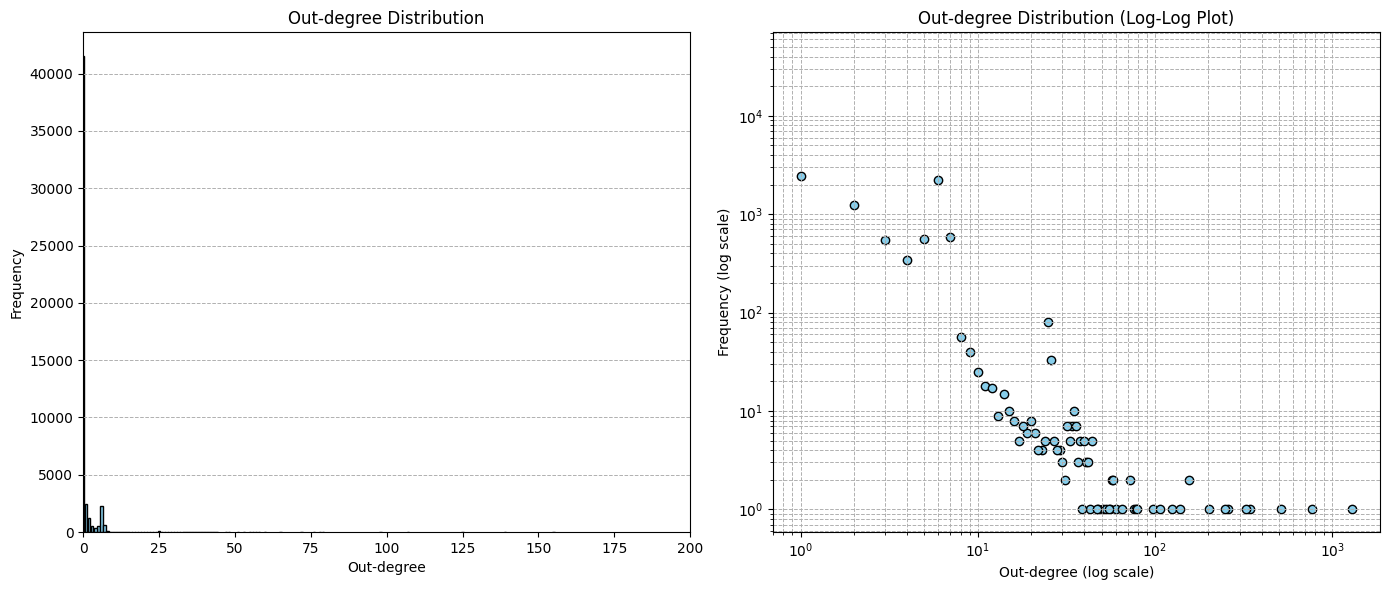

In [17]:
plot_degree_distribution_igraph(in_degree_dict, degree_type='out')

# 3

In [18]:
# Funzione per trovare la componente connessa più grande
def find_largest_connected_component_igraph(graph):
    """
    Trova la componente connessa più grande in un grafo non diretto usando igraph.
    Restituisce il sottografo della LCC.
    """
    components = graph.connected_components(mode="WEAK")  # Trova le componenti connesse debolmente
    largest_component = components.giant()  # Restituisce la componente più grande
    return largest_component

# Funzione per calcolare l'eccentricità di un nodo usando igraph
def bfs_eccentricity_igraph(graph, start_node):
    """
    Calcola l'eccentricità di un nodo usando BFS con igraph.
    Restituisce l'eccentricità e il nodo più distante.
    """
    shortest_paths = graph.distances(source=start_node)[0]
    max_distance = max(shortest_paths)
    farthest_node = shortest_paths.index(max_distance)
    return max_distance, farthest_node


# Funzione per BFS bidirezionale semplificata per trovare la distanza tra due nodi
def bidirectional_bfs_igraph(graph, start_node, target_node):
    """
    Implementa una BFS bidirezionale tra start_node e target_node in igraph.
    Restituisce la distanza minima tra i due nodi o -1 se non sono connessi.
    """
    if start_node == target_node:
        return 0

    shortest_paths = graph.distances(source=start_node, target=target_node)[0][0]
    return shortest_paths if shortest_paths != float('inf') else -1



# Funzione per BFS fringe (nodi a distanza 'depth')
def bfs_fringe_igraph(graph, start_node, depth):
    """
    Trova i nodi a distanza 'depth' dal nodo di partenza usando BFS con igraph.
    """
    fringe_nodes = []
    all_shortest_paths = graph.distances(source=start_node)[0]

    fringe_nodes = [node for node, distance in enumerate(all_shortest_paths) if distance == depth]
    return fringe_nodes


# Algoritmo iFub ottimizzato per calcolare il diametro con igraph
def ifub_diameter_igraph(graph):
    """
    Calcola il diametro del grafo usando l'algoritmo iFub ottimizzato con BFS bidirezionale.
    """
    # Step 1: Inizia con un nodo qualsiasi
    start_node = 0

    # Step 2: Calcola l'eccentricità iniziale con BFS e trova il nodo più lontano
    _, farthest_node = bfs_eccentricity_igraph(graph, start_node)

    # Step 3: Imposta i limiti iniziali
    lb, farthest_node = bfs_eccentricity_igraph(graph, farthest_node)
    ub = 2 * lb  # Upper bound è il doppio del limite inferiore
    i = lb

    while ub > lb:
        # Step 4: Trova la fringe a distanza 'i' dal nodo più lontano
        fringe_nodes = bfs_fringe_igraph(graph, farthest_node, i)

        # Step 5: Trova l'eccentricità massima tra i nodi nella fringe con BFS bidirezionale
        max_eccentricity_in_fringe = 0
        for node in fringe_nodes:
            eccentricity = bidirectional_bfs_igraph(graph, farthest_node, node)
            max_eccentricity_in_fringe = max(max_eccentricity_in_fringe, eccentricity)

        # Aggiorna i limiti
        lb = max(lb, max_eccentricity_in_fringe)
        ub = 2 * (i - 1)
        i -= 1

    return lb  # Il diametro si trova quando i limiti convergono


# Funzione per rimuovere i nodi 'disambigua'
def remove_disambigua_nodes_igraph(graph, id_to_name):
    """
    Rimuove i nodi che contengono 'disambigua' nel nome e ritorna il grafo ridotto in igraph.
    """
    nodes_to_remove = [v.index for v in graph.vs if 'disambigua' in id_to_name[v.index].lower()]
    graph.delete_vertices(nodes_to_remove)
    return graph

# Funzione pipeline per calcolare il diametro
def pipeline_igraph(graph, id_to_name):
    """
    Calcola il diametro del grafo con e senza nodi 'disambigua' in igraph.
    """
    # Calcolo con i nodi 'disambigua'
    start_time = time.time()
    print("Calcolo con nodi 'disambigua'...")
    largest_cc = find_largest_connected_component_igraph(graph)
    diameter = ifub_diameter_igraph(largest_cc)
    print(f"Diametro iFub: {diameter}")
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")
    
    # Calcolo senza nodi 'disambigua'
    start_time = time.time()
    print("Rimozione dei nodi 'disambigua' e ricalcolo...")
    graph_cleaned = remove_disambigua_nodes_igraph(graph.copy(), id_to_name)
    largest_cc = find_largest_connected_component_igraph(graph_cleaned)
    diameter = ifub_diameter_igraph(largest_cc)
    print(f'Diametro iFub (senza nodi disambigua): {diameter}')
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")


pipeline_igraph(U_G, id_to_name)

Calcolo con nodi 'disambigua'...
Diametro iFub: 15
Tempo di esecuzione: 4.97 secondi

Rimozione dei nodi 'disambigua' e ricalcolo...
Diametro iFub (senza nodi disambigua): 15
Tempo di esecuzione: 5.30 secondi



In [19]:
# Algoritmo Bron-Kerbosch modificato per trovare cliques massimali
def bron_kerbosch_igraph(R, P, X, graph, maximal_cliques, max_cliques_needed=2):
    """
    Algoritmo Bron-Kerbosch modificato per trovare cliques massimali utilizzando igraph.

    Parametri:
    - R: Insieme dei nodi che sono già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono ancora essere aggiunti alla clique.
    - X: Insieme dei nodi che non possono più essere inclusi nella clique (già processati).
    - graph: Il grafo su cui viene eseguito l'algoritmo (di tipo igraph).
    - maximal_cliques: Lista dove vengono salvate le cliques massimali trovate.
    - max_cliques_needed: Numero massimo di cliques da trovare (valore di default 2).
    """
    # Se P e X sono vuoti, significa che abbiamo trovato una clique massimale.
    if not P and not X:
        if len(R) >= 3:  # Consideriamo solo cliques con almeno 3 nodi (clique non banali)
            maximal_cliques.append(R)  # Aggiungi la clique massimale trovata alla lista
        return

    # Se abbiamo già trovato il numero massimo di cliques richieste, fermati.
    if len(maximal_cliques) >= max_cliques_needed:
        return

    # Scegli un nodo pivot da P ∪ X per limitare il numero di ricorsioni.
    pivot = next(iter(P.union(X)), None)
    if pivot is None:
        return

    # Processa i nodi in P che non sono vicini del pivot
    for node in P - set(graph.neighbors(pivot)):
        bron_kerbosch_igraph(
            R.union([node]),  # Aggiungi il nodo corrente alla clique R
            P.intersection(set(graph.neighbors(node))),  # Limita P ai vicini del nodo aggiunto
            X.intersection(set(graph.neighbors(node))),  # Limita X ai vicini del nodo aggiunto
            graph, maximal_cliques, max_cliques_needed
        )
        P.remove(node)
        X.add(node)

# Funzione per trovare più cliques massimali non banali con Bron-Kerbosch
def find_maximal_cliques_bron_kerbosch_igraph(graph, id_to_name, max_cliques_needed=2):
    """
    Funzione che avvia l'algoritmo Bron-Kerbosch per trovare più cliques massimali non banali.

    Parametri:
    - graph: Il grafo in cui si vogliono trovare le cliques massimali (di tipo igraph).
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - max_cliques_needed: Numero massimo di cliques massimali da trovare.

    Ritorna:
    - Una lista con le cliques massimali trovate.
    """
    R = set()  # Insieme iniziale vuoto (clique corrente)
    P = set(graph.vs.indices)  # Tutti i nodi sono candidati iniziali per essere inclusi nella clique
    X = set()  # Insieme vuoto, non ci sono nodi esclusi all'inizio

    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch per trovare le cliques massimali
    bron_kerbosch_igraph(R, P, X, graph, maximal_cliques, max_cliques_needed)

    # Stampa le cliques massimali trovate, convertendo gli ID nei nomi
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]  # Converte gli ID dei nodi nei loro nomi
        print(f"Clique massimale {idx}: {clique_names}")  # Stampa la clique massimale con i nomi dei nodi

    return maximal_cliques  # Restituisce la lista delle cliques massimali trovate

# Esegui l'algoritmo per trovare due cliques massimali con i nomi dei nodi
maximal_cliques = find_maximal_cliques_bron_kerbosch_igraph(U_G, id_to_name, max_cliques_needed=2)


Clique massimale 1: ['La Cultura station', 'San Borja Sur station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 2: ['La Cultura station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro', 'Arriola station']


#### Modifica l'algoritmo che hai scelto nella Domanda 3 per produrre tutte le soluzioni, ad esempio tutte le clique massimali, stampando tutte le soluzioni esattamente una volta. Questo potrebbe richiedere molto tempo. Puoi limitarti a un sottografo casuale di 100 vertici e far funzionare il tuo algoritmo solo su quello. 

In [20]:
def bron_kerbosch(R, P, X, graph, maximal_cliques):
    """
    Algoritmo Bron-Kerbosch modificato per trovare tutte le cliques massimali con almeno 3 nodi in un grafo.
    
    Parametri:
    - R: Insieme dei nodi che sono già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono ancora essere aggiunti alla clique.
    - X: Insieme dei nodi che non possono più essere inclusi nella clique (già processati).
    - graph: Il grafo su cui viene eseguito l'algoritmo.
    - maximal_cliques: Lista dove vengono salvate le cliques massimali trovate.
    """
    if not P and not X:
        if len(R) >= 3:  # Aggiungi la clique massimale solo se ha almeno 3 nodi
            maximal_cliques.append(R)
        return
    
    for node in list(P):
        bron_kerbosch(
            R.union([node]),  # Aggiungi il nodo corrente alla clique R
            P.intersection(set(graph.neighbors(node))),  # Limita P ai vicini del nodo aggiunto
            X.intersection(set(graph.neighbors(node))),  # Limita X ai vicini del nodo aggiunto
            graph, maximal_cliques
        )
        P.remove(node)  # Rimuovi il nodo processato da P
        X.add(node)     # Aggiungi il nodo processato a X (ora è escluso)
        
def find_all_maximal_cliques_bron_kerbosch(graph, id_to_name):
    """
    Trova tutte le cliques massimali nel grafo utilizzando l'algoritmo Bron-Kerbosch senza la condizione di minimo 3 nodi.

    Parametri:
    - graph: Il grafo in cui si vogliono trovare le cliques massimali.
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.

    Ritorna:
    - Una lista con tutte le cliques massimali trovate.
    """
    R = set()  # Insieme iniziale vuoto (clique corrente)
    P = set(range(graph.vcount()))  # Tutti i nodi sono candidati iniziali per essere inclusi nella clique
    X = set()  # Insieme vuoto, non ci sono nodi esclusi all'inizio
    
    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch per trovare tutte le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques)

    # Stampa le cliques massimali trovate, convertendo gli ID nei nomi
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]  # Converte gli ID dei nodi nei loro nomi
        print(f"Clique massimale {idx}: {clique_names}")  # Stampa la clique massimale con i nomi dei nodi

    return maximal_cliques  # Restituisce la lista delle cliques massimali trovate

max_lines = 10000000 # Numero massimo di righe di archi da processare
max_nodes = 100 # Numero massimo di nodi da aggiungere

# Crea il grafo utilizzando solo i primi max_lines archi e i primi max_nodes nodi
G, U_G, id_to_name, name_to_id = create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines, max_nodes)

print(f"Numero di nodi nel grafo: {len(G.vs)}\nNumero di archi nel grafo: {len(G.es)}")

# Trova tutte le cliques massimali nel sottografo
maximal_cliques = find_all_maximal_cliques_bron_kerbosch(U_G, id_to_name)


Numero di nodi nel grafo: 100
Numero di archi nel grafo: 230
Clique massimale 1: ['La Cultura station', 'San Borja Sur station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 2: ['La Cultura station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro', 'Arriola station']
Clique massimale 3: ['San Borja Sur station', 'Angamos station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 4: ['San Juan station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro', 'María Auxiliadora station', 'Villa El Salvador station']
Clique massimale 5: ['Miguel Grau station', 'Atocongo station', 'Villa María station', 'Pumacahua station', 'List of Lima Metro stations', 'Lima Metro', 'Villa El Salvador station']
Clique massimale 6: ['Miguel Grau station', 'Atocongo station', 'Villa María station', 'List of Lima Metro stat

#### Modifica l'algoritmo per trovare il minimo (se stiamo cercando un minimale) o il massimo (se stiamo cercando un massimale), rispettivamente la soluzione con il minor numero di elementi o con il maggior numero di elementi.


In [21]:
def find_largest_maximal_clique_bron_kerbosch(graph, id_to_name):
    """
    Trova la clique massimale più grande nel grafo utilizzando l'algoritmo Bron-Kerbosch.

    Parametri:
    - graph: Il grafo in cui si vuole trovare la clique massimale più grande.
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.

    Ritorna:
    - La clique massimale più grande trovata.
    """
    R = set()  # Insieme iniziale vuoto (clique corrente)
    P = set(range(graph.vcount()))  # Tutti i nodi sono candidati iniziali per essere inclusi nella clique
    X = set()  # Insieme vuoto, non ci sono nodi esclusi all'inizio
    
    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch per trovare tutte le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques)

    # Trova la clique massimale più grande
    largest_clique = max(maximal_cliques, key=len)

    # Stampa la clique massimale più grande, convertendo gli ID nei nomi
    clique_names = [id_to_name[node] for node in largest_clique]  # Converte gli ID dei nodi nei loro nomi
    print(f"Clique massimale più grande: {clique_names}")

    return largest_clique  # Restituisce la clique massimale più grande

largest_clique = find_largest_maximal_clique_bron_kerbosch(U_G, id_to_name)

Clique massimale più grande: ['San Juan station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro', 'María Auxiliadora station', 'Villa El Salvador station']
